**Introduction:**

State Preparation is a cornerstone of quantum algorithms and applications, enabling the initialization of quantum systems into specific states as a starting point for subsequent operations. Its efficiency directly impacts the accuracy and scalability of quantum computations.

A particular interest is the Gaussian state preparation, which is essential for simulating physical systems and tackling problems in quantum chemistry, machine learning, and optimization. Gaussian states, characterized by their Gaussian-shaped wavefunctions, are powerful tools for encoding probability distributions and modeling quantum systems.

The aim of this project is to leverage Classiq's quantum computing SDK to implement a Gaussian State preparation in the interval [-2, 2).

**Target State: The Gaussian State Representation**

The Gaussian state is defined as:

$$
|x_0\rangle_N = |0\rangle_N \longrightarrow \sum_{|x\rangle_N} \sqrt{G(x)} |x\rangle_N
$$

Where $G(x)$ is represented as a vector:

$$
{G}(x_i) = \frac{\exp(-\lambda \cdot {x_i}^2)}{\sum_{x' \in \text{domain}} \exp(-\lambda \cdot (x')^2)} \text{, for } x_i \in \text{domain}
$$


- $G(x)$ is the normalized Gaussian vector across the discrete domain.  
- $\vec{x}$ represents the set of discrete points in the domain.  
- $\lambda$ represents the decay rate. In the code, it is represented by the variable $\text{EXP_RATE}$, which controls the spread of the Gaussian.
- The denominator ensures normalization across the entire domain.

**<h1>The Code</h1>**

Step 1: Installing Classiq

In [2]:
!pip install classiq

Step 2: Importing and authenticating the device

In [15]:
import classiq
# classiq.authenticate() # Uncoment to authenticate. For the first (local) run only

Step 3: Importing necessary libraries/modules

In [4]:
from classiq import *
from classiq.execution import *
from classiq.qmod.symbolic import *
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

Step 4: Creating the 'Gaussian Preparation' program

In [5]:
def create_solution(resolution: int):
    EXP_RATE = 1

    def gaussian_amps(N):
        domain = np.linspace(start=-2, stop=2, num=N, endpoint=False)

        normalization_constant = np.sum(np.exp(-EXP_RATE * domain ** 2))

        vector = np.exp(-EXP_RATE * domain ** 2) / normalization_constant

        return np.sqrt(vector).tolist()


    @qfunc
    def prepare_gaussian(x: QNum):
        amplitudes = gaussian_amps(2 ** resolution)
        inplace_prepare_state(amplitudes=amplitudes, bound=0 ,target=x)
    return prepare_gaussian

Step 5: Creating the Quantum Model

In [9]:
def create_qprog(resolution: int, num_shots: int=1, optimization_parameter: str="CX"):
    prepare_gaussian_function = create_solution(resolution)
    fraction_digits = resolution - 2

    @qfunc
    def main(x: Output[QNum[resolution, SIGNED, fraction_digits]]):
        # Allocate the quantum variable x with the specified resolution
        allocate(x.size, x)

        # Prepare Gaussian state
        prepare_gaussian_function(x)


    # Backend preferences for the state vector simulator
    backend_preferences = ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    )

    # Generate the quantum model
    qmod = create_model(
        main,
        execution_preferences=ExecutionPreferences(
            num_shots=num_shots, backend_preferences=backend_preferences
        ),
        constraints=Constraints(
            max_width=18, optimization_parameter=optimization_parameter
        ),
    )


    # Synthesize the quantum program
    qprog = synthesize(qmod)

    return qprog

  Step 6: The Quantum Program (on 7 qubits)

In [10]:
qprogram = create_qprog(resolution=7)

Step 7: Obtaining the results

In [11]:
result = execute(qprogram).get_sample_result()

Step 8: Visualization of Results (Determining Mean-Squared Error, comparing with Theoretical Gaussian)

In [12]:
# Stage 1:

def scatter_aggregated_amplitudes_with_theory(parsed_state_vector, resolution: int, should_plot: bool=True):
    """
    Aggregate squared amplitudes by x, sum them, and scatter plot with theoretical distribution.
    Also calculates Mean Squared Error (MSE).

    Parameters:
        res: Parsed state vector results (list of SimulatedState objects).
        exp_rate: Exponential rate for the Gaussian distribution.
        resolution: Number of qubits used in the Gaussian state.
        should_plot: bool that allow you to choose if to plot the solution
    """
    from collections import defaultdict
    fraction_digits = resolution - 2
    EXP_RATE = 1

    # Initialize a dictionary to store sums of squared amplitudes
    amplitude_sums = defaultdict(int)
    for state in parsed_state_vector:
        amplitude_sums[state.state['x']] += np.abs(state.amplitude)**2

    # Prepare data for plotting
    x_values = sorted(amplitude_sums)  # Sort for meaningful plotting
    summed_squared_norms = [amplitude_sums[x] for x in x_values]

    # Generate theoretical Gaussian distribution
    grid = np.linspace(-2**(resolution-fraction_digits-1), 2**(resolution-fraction_digits-1)-2**(-fraction_digits), 2**(resolution))

    theoretical_gaussian = np.exp(-EXP_RATE * grid**2)
    theoretical_gaussian /= np.sum(theoretical_gaussian)  # Normalize the Gaussian

    # Interpolate theoretical probabilities at measured points
    interp_func = np.interp(x_values, grid, theoretical_gaussian)
    interpolated_theoretical_prob = interp_func

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((np.array(summed_squared_norms) - interpolated_theoretical_prob)**2)
    print("Mean Squared Error (MSE):", mse)

    # Plot measured and theoretical distributions
    if should_plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(x_values, summed_squared_norms, color='blue', alpha=0.7, label='Measured (Summed Squared Norms)')
        plt.plot(grid, theoretical_gaussian, color='red', linewidth=2, label='Theoretical Gaussian')
        plt.xlabel('x')
        plt.ylabel('Probability')
        plt.title('Measured vs Theoretical Gaussian')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return mse

Mean Squared Error (MSE): 0.00014582382054900754


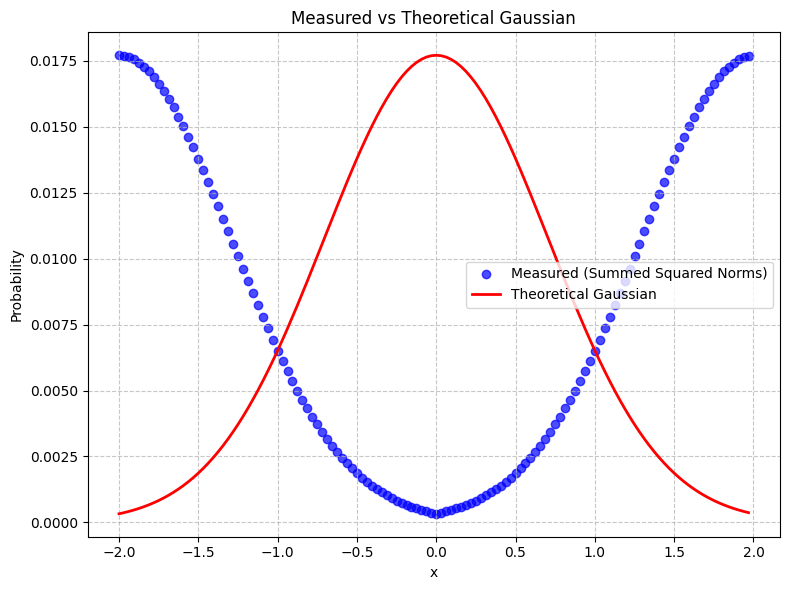

In [13]:
mse = scatter_aggregated_amplitudes_with_theory(result.parsed_state_vector, 7, should_plot=True)